In [1]:
import sys, os
import numpy as np
import pandas as pd

from utils import default_paths, nsd_utils, prf_utils, numpy_utils
from model_fitting import initialize_fitting 
from analyze_fits import analyze_gabor_params

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import load_fits, plot_utils

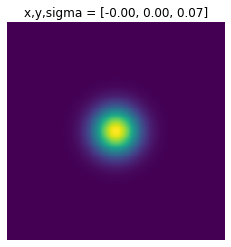

In [2]:
# going to load a few images and plot those that have highest activation for 
# a given feature type. Can get an idea of what image components these features relate to. 

which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)
mm = 400

x,y,sigma = models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)

plt.figure();
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

In [3]:
# load a set of gabor features

from feature_extraction import fwrf_features
subject=1
n_ori = 12; n_sf = 8;
feat_loader = fwrf_features.fwrf_feature_loader(subject=subject ,which_prf_grid=which_prf_grid,\
                                                feature_type='gabor_solo', \
                                                n_ori=12, n_sf=8, nonlin=True)
ims2use = np.arange(0,1000)
features_in_prf, defin = feat_loader.load(ims2use,mm)
features_in_prf.shape

Loading pre-computed features for models [400 - 499] from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_12ori_8sf_gabor_solo_nonlin_grid5.h5py
Took 2.42467 seconds to load file
Size of features array for this image set is:
(1000, 96, 100)
Index into batch for prf 400: 0
Size of features array for this image set and prf is:
(1000, 96)
Final size of feature matrix is:
(1000, 96)


(1000, 96)

In [4]:
image_data = nsd_utils.get_image_data(subject)
image_data = image_data[ims2use,:,:,:]
image_data = nsd_utils.image_uncolorize_fn(image_data)

image_data.shape


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


(1000, 1, 240, 240)

In [5]:
labels_folder = os.path.join(default_paths.stim_labels_root, \
                     'S%d_within_prf_grid%d'%(subject,which_prf_grid))
labels_fn = os.path.join(default_paths.stim_labels_root,'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                 'S%d_concat_prf%d.csv'%(subject, mm))
print('loading from %s'%(labels_fn))
coco_df = pd.read_csv(labels_fn, index_col=0)


loading from /user_data/mmhender/nsd/labels/S1_within_prf_grid5/S1_concat_prf400.csv


In [7]:
coco_df.keys()

Index(['indoor_outdoor', 'natural_humanmade', 'animacy',
       'real_world_size_binary', 'real_world_size_continuous', 'accessory',
       'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor',
       'kitchen', 'outdoor', 'person', 'sports', 'vehicle', 'within_accessory',
       'within_animal', 'within_appliance', 'within_electronic', 'within_food',
       'within_furniture', 'within_indoor', 'within_kitchen', 'within_outdoor',
       'within_sports', 'within_vehicle', 'building', 'ceiling', 'floor',
       'food-stuff', 'furniture-stuff', 'ground', 'other', 'plant',
       'raw-material', 'sky', 'solid', 'structural', 'textile', 'wall',
       'water', 'window', 'within_building', 'within_floor',
       'within_food-stuff', 'within_furniture-stuff', 'within_ground',
       'within_plant', 'within_raw-material', 'within_solid',
       'within_structural', 'within_textile', 'within_wall', 'within_water'],
      dtype='object')

In [8]:
dd = 0
name = 'indoor_outdoor'

labels = np.array(coco_df[name])[ims2use]
inds2use = ~np.isnan(labels)

labels.shape

(1000,)

In [9]:
from feature_extraction import gabor_feature_extractor

_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

In [11]:
# Gather information about the gabor feature channels
sf_unique, ori_unique = analyze_gabor_params.get_gabor_feature_info(n_ori=12, n_sf=8)
n_sf = len(sf_unique)
n_ori = len(ori_unique)


74 deg, 1.394 cyc/deg


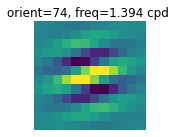

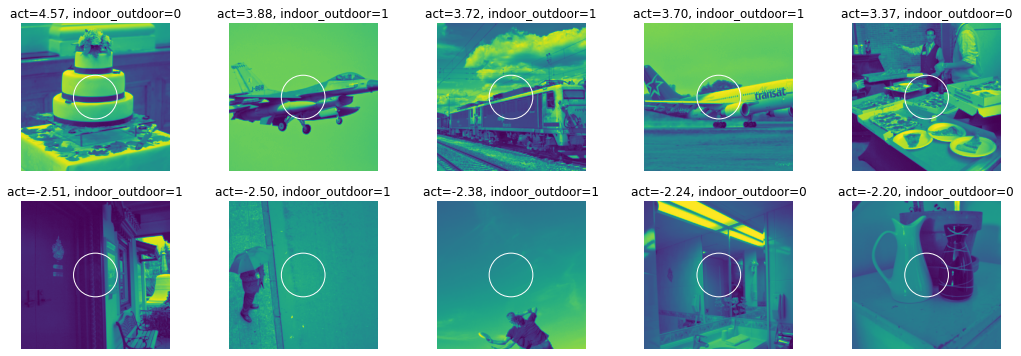

In [13]:
oo = 5;
sf = 3;
ff = sf*n_ori+oo

print('%d deg, %.3f cyc/deg'%(ori_unique[oo], sf_unique[sf]))

zvals = scipy.stats.zscore(features_in_prf[:,ff])
orient_filters_complex = np.real(_gabor_ext_complex.filter_stack)
feature_im = orient_filters_complex[oo,0,:,:]

plt.figure(figsize=(2,2));
plt.pcolormesh(feature_im)
plt.gca().invert_yaxis()
plt.axis('off')
# plt.axis('square')
plt.suptitle('orient=%d, freq=%.3f cpd'%(ori_unique[oo], sf_unique[sf]))

top_n = 5
top_image_inds = np.flip(np.argsort(zvals))[0:top_n]
bottom_image_inds = np.argsort(zvals)[0:top_n]
top_resp = zvals[top_image_inds]
bottom_resp = zvals[bottom_image_inds]
top_images = image_data[top_image_inds,0,:,:]
bottom_images = image_data[bottom_image_inds,0,:,:]

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(18,6));
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1);
    plt.imshow(top_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f, %s=%.0f'%(top_resp[ii], name, labels[top_image_inds[ii]]))
for ii in range(top_n):
    ax = plt.subplot(2,top_n,ii+1+top_n);    
    plt.imshow(bottom_images[ii,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('act=%.2f, %s=%.0f'%(bottom_resp[ii], name, labels[bottom_image_inds[ii]]))
